# CSCN8020 — Assignment 1
**Student Name:** Yogesh Kumar Gopal  
**Student ID:** 8996403  
**Course:** Reinforcement Learning Programming 

## Problem 1: Pick and Place Robot as an MDP

The pick and place robot control problem can be formulated as a Markov Decision Process (MDP):

- **States:** Describe the robot's current joint positions and velocities as continuous values, along with whether the gripper is holding an object.

- **Actions:** The robot controls its motors directly by issuing continuous motor commands or torques for each joint.

- **Rewards:**  
  +10 for successfully placing the object at the goal,  
  -1 for each time step to encourage speed,  
  A penalty for sudden changes in acceleration or torque (which encourages smooth movement), and  
  -5 for any failures such as dropping the object.

- **Episode Ends:** When the object is placed successfully, a failure occurs, or a time limit is reached.

This MDP setup ensures the robot learns to move quickly and smoothly while successfully completing the pick and place task.
This setup helps the robot learn to pick and place objects efficiently and smoothly by adjusting motor commands directly.



In [4]:

class PickPlaceRobotEnv:
    def __init__(self):
        # State: (position, holding)
        # position: 0 = at pick, 1 = at place
        # holding: 0 = not holding, 1 = holding object
        self.states = [(0, 0), (0, 1), (1, 0), (1, 1)]
        self.state = (0, 0)
        self.steps = 0
    
    def reset(self):
        self.state = (0, 0)
        self.steps = 0
        return self.state
    
    def step(self, action):
        pos, hold = self.state
        reward = -1   # time penalty every step
        self.steps += 1
        
        if action == 'pick':
            if pos == 0 and hold == 0:
                hold = 1
            else:
                reward -= 5  # penalty for failed or jerky pick
        elif action == 'move_to_place':
            if pos == 0 and hold == 1:
                pos = 1
            else:
                reward -= 5
        elif action == 'place':
            if pos == 1 and hold == 1:
                hold = 0
                reward += 10  # success!
            else:
                reward -= 5
        else:
            reward -= 5  # invalid action
        
        # Example jerk penalty (here, just for illustration)
        if abs(pos - self.state[0]) > 0 and abs(hold - self.state[1]) > 0:
            reward -= 2  # Moving & picking at same time (not smooth)
        self.state = (pos, hold)
        done = (reward >= 9) or (self.steps >= 10)
        return self.state, reward, done

    def render(self):
        pos, hold = self.state
        print(f"Position: {'Pick' if pos==0 else 'Place'}, Holding: {bool(hold)}")

# Demo run (illustrative policy)
env = PickPlaceRobotEnv()
state = env.reset()
done = False
actions = ['pick', 'move_to_place', 'place']
print("Pick-and-Place Robot MDP Demo")
while not done and actions:
    env.render()
    action = actions.pop(0)
    state, reward, done = env.step(action)
    print(f"Action: {action}, Reward: {reward}, New state: {state}")
env.render()

Pick-and-Place Robot MDP Demo
Position: Pick, Holding: False
Action: pick, Reward: -1, New state: (0, 1)
Position: Pick, Holding: True
Action: move_to_place, Reward: -1, New state: (1, 1)
Position: Place, Holding: True
Action: place, Reward: 9, New state: (1, 0)
Position: Place, Holding: False


## Problem 2: 2x2 Gridworld Value Iteration Values

| State | Reward \(R(s)\) |
|-------|-----------------|
| s1    | 5               |
| s2    | 10              |
| s3    | 1               |
| s4    | 2               |

Discount factor \(\gamma = 0.9\).

### Value Iteration Step 1:

Initial values \(V_0(s) = 0\).

Calculate \(Q(s,a) = R(s) + \gamma V_0(s')\) for each action and choose max.

- For s1:

| Action | Next State | \(Q(s,a) = R(s) + \gamma V_0(s')\) |
|--------|------------|------------------------------------|
| up     | s1         | 5 + 0.9*0 = 5                      |
| down   | s3         | 5 + 0.9*0 = 5                      |
| left   | s1         | 5 + 0.9*0 = 5                      |
| right  | s2         | 5 + 0.9*0 = 5                      |

Max \(V_1(s1) = 5\), action any of above.

- For s2:

| Action | Next State | Value             |
|--------|------------|-------------------|
| up/down/left/right | respective next states | 10 + 0.9*0 = 10 |

Max \(V_1(s2) = 10\).

- For s3:

All actions lead to states with zero \(V_0\), so max \(V_1(s3) = 1\).

- For s4:

All actions lead to zero \(V_0\), so max \(V_1(s4) = 2\).

### Values after Iteration 1:

| State | \(V_1(s)\) |
|-------|------------|
| s1    | 5          |
| s2    | 10         |
| s3    | 1          |
| s4    | 2          |

---

### Value Iteration Step 2:

Using \(V_1(s)\) from above, calculate:

- For s1:

| Action | Next State | Q-val                        |
|--------|------------|-----------------------------|
| up     | s1         | \(5 + 0.9 \times 5 = 9.5\)     |
| down   | s3         | \(5 + 0.9 \times 1 = 5.9\)     |
| left   | s1         | 9.5                         |
| right  | s2         | \(5 + 0.9 \times 10 = 14\)      |

Max \(V_2(s1) = 14\), take 'right' action.

- For s2:

| Actions and Q-vals  |
|---------------------|
| up: \(10 + 0.9 \times 10 = 19\) |
| down: \(10 + 0.9 \times 2 = 11.8\) |
| left: \(10 + 0.9 \times 5 = 14.5\) |
| right: \(10 + 0.9 \times 10 = 19\) |

Max \(V_2(s2) = 19\) (up or right).

- For s3:

| Actions            | Q-val               |
|--------------------|---------------------|
| up: \(1 + 0.9 \times 5 = 5.5\)  |
| down/left/right: ~ 2           |

Max \(V_2(s3) = 5.5\).

- For s4:

| Actions                 | Q-val               |
|-------------------------|---------------------|
| up: \(2 + 0.9 \times 10 = 11\)  |
| down/left/right: ~ 3          |

Max \(V_2(s4) = 11\).

### Values after Iteration 2:

| State | \(V_2(s)\) |
|-------|------------|
| s1    | 14         |
| s2    | 19         |
| s3    | 5.5        |
| s4    | 11         |


### Summary Explanation

The value iteration process updates the estimated value of each state by considering the immediate reward plus the discounted value of the best next state reachable by any action.

- In the **first iteration**, values update from their initial zero values to the immediate rewards since future values are zero.
- In the **second iteration**, values start incorporating the potential future rewards by looking ahead one step.
- This iterative process continues until the value function converges, meaning further updates no longer significantly change the value estimates.
- The resulting value function guides the optimal policy by selecting, at each state, the action leading to the highest expected return.

---------------------------


## Problem 3: Value Iteration on 5x5 Gridworld

Value Iteration is a dynamic programming method to compute the optimal value function and policy for an MDP.

- Starting from an initial guess, the value function is iteratively updated using the Bellman optimality equation which incorporates the expected reward and discounted future values.
- For each state, the best action is chosen that maximizes expected return.
- Iterations continue until changes in the value function are below a convergence threshold.
- The resulting value function represents the maximum expected rewards achievable from each state under the optimal policy.
- The extracted policy indicates the best action to take at each state to maximize rewards.


Value iteration finished in 9 iterations, time: 0.0000s
Value function V*:
[[-0.43  0.63  1.81  3.12  4.58]
 [ 0.63  1.81  3.12  4.58  6.2 ]
 [ 1.81  3.12  4.58  6.2   8.  ]
 [ 3.12  4.58  6.2   8.   10.  ]
 [ 4.58  6.2   8.   10.    0.  ]]
Extracted policy:
R R R D D
R R R R D
R D R R D
R R R R D
R R R R G


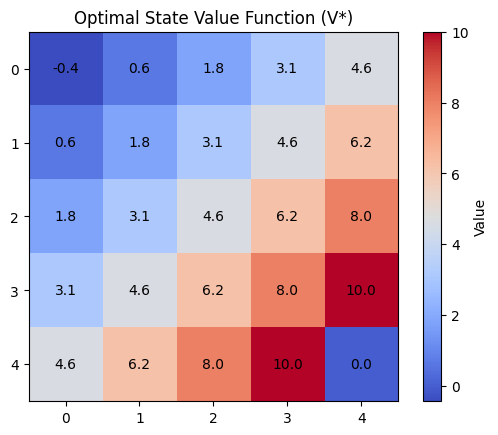

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import time

random.seed(42)
np.random.seed(42)

class GridWorld:
    def __init__(self, size=5):
        self.size = size
        self.V = np.zeros((size, size))
        self.terminal_state = (size-1, size-1)
        self.grey_states = {(2, 2), (3, 0), (0, 4)}
        self.actions = [(0,1), (0,-1), (1,0), (-1,0)]
        self.action_names = ["Right", "Left", "Down", "Up"]
        self.gamma = 0.9
        self.theta = 1e-4

    def reward(self, state):
        if state == self.terminal_state:
            return 10
        elif state in self.grey_states:
            return -5
        else:
            return -1

    def in_bounds(self, i, j):
        return 0 <= i < self.size and 0 <= j < self.size

    def step(self, state, action_idx):
        i, j = state
        di, dj = self.actions[action_idx]
        ni, nj = i+di, j+dj
        if not self.in_bounds(ni, nj):
            return (i, j)
        return (ni, nj)

    def value_iteration(self):
        iterations = 0
        while True:
            delta = 0
            new_V = np.copy(self.V)
            for i in range(self.size):
                for j in range(self.size):
                    if (i, j) == self.terminal_state:
                        continue
                    values = []
                    for a in range(len(self.actions)):
                        ns = self.step((i,j), a)
                        r = self.reward(ns)
                        values.append(r + self.gamma * self.V[ns])
                    best = max(values)
                    new_V[i, j] = best
                    delta = max(delta, abs(new_V[i, j] - self.V[i, j]))
            self.V = new_V
            iterations += 1
            if delta < self.theta:
                break
        return iterations

    def extract_policy(self):
        policy = np.full((self.size, self.size), ' ')
        for i in range(self.size):
            for j in range(self.size):
                if (i,j) == self.terminal_state:
                    policy[i, j] = 'G'
                    continue
                best_a = None
                best_val = float('-inf')
                for a in range(len(self.actions)):
                    ns = self.step((i,j), a)
                    val = self.reward(ns) + self.gamma * self.V[ns]
                    if val > best_val:
                        best_val = val
                        best_a = a
                policy[i, j] = self.action_names[best_a]
        return policy

# Create environment and run value iteration
grid = GridWorld()
start_time = time.time()
iters = grid.value_iteration()
end_time = time.time()

print(f"Value iteration finished in {iters} iterations, time: {end_time - start_time:.4f}s")

print("Value function V*:")
print(np.round(grid.V, 2))

policy = grid.extract_policy()
print("Extracted policy:")
for row in policy:
    print(" ".join(row))

# Plot value function heatmap
plt.imshow(grid.V, cmap='coolwarm')
plt.colorbar(label='Value')
plt.title("Optimal State Value Function (V*)")
for i in range(grid.size):
    for j in range(grid.size):
        plt.text(j, i, f"{grid.V[i,j]:.1f}", ha='center', va='center', color='black')
plt.show()


## Problem 4: Off Policy Monte Carlo with Importance Sampling

Off Policy Monte Carlo with Importance Sampling (IS) estimates the value function for a target (greedy) policy using episodes generated from a different behavior (random) policy.

- Importance Sampling weights each sample return inversely proportional to the probability of its occurrence under the behavior policy compared to the target policy.
- Ordinary IS can suffer from high variance especially when behavior and target policies differ greatly.
- Weighted IS normalizes these weights to reduce variance and improve stability.
- This approach allows evaluation of a target policy without needing the model, using only sampled experience.
- Over many episodes, the estimated value function approaches the true value function of the target policy.


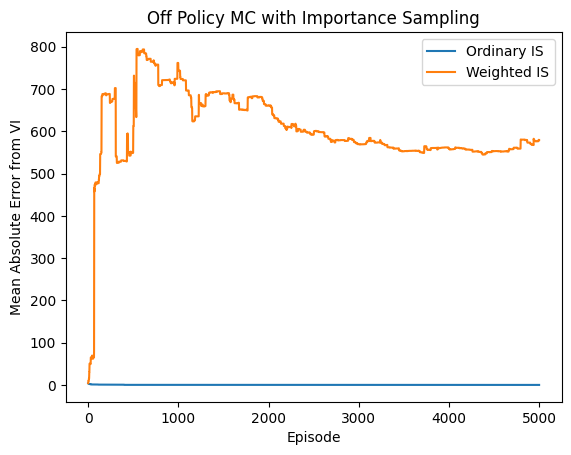

Final MAE (Ordinary IS): 0.3186
Final MAE (Weighted IS): 579.1439


In [2]:
def behavior_policy(env):
    return random.choice(range(len(env.actions)))

def generate_episode(env, max_steps=100):
    state = (random.randint(0, env.size - 1), random.randint(0, env.size - 1))
    while env.terminal_state == state:
        state = (random.randint(0, env.size - 1), random.randint(0, env.size - 1))
    episode = []
    for _ in range(max_steps):
        action = behavior_policy(env)
        next_state = env.step(state, action)
        reward = env.reward(next_state)
        episode.append((state, action, reward))
        if next_state == env.terminal_state:
            break
        state = next_state
    return episode

def greedy_policy_from_V(env):
    policy = {}
    for i in range(env.size):
        for j in range(env.size):
            if (i, j) == env.terminal_state:
                continue
            best_a = None
            best_val = float('-inf')
            for a in range(len(env.actions)):
                ns = env.step((i, j), a)
                val = env.reward(ns) + env.gamma * env.V[ns]
                if val > best_val:
                    best_val = val
                    best_a = a
            policy[(i, j)] = best_a
    return policy

def off_policy_mc_is(env, num_episodes=5000, weighted=False):
    V = np.zeros((env.size, env.size))
    C = np.zeros((env.size, env.size))
    target_policy = greedy_policy_from_V(env)
    gamma = env.gamma
    errors = []

    for _ in range(num_episodes):
        episode = generate_episode(env)
        G = 0
        W = 1.0
        for t in reversed(range(len(episode))):
            state, a, r = episode[t]
            G = gamma * G + r
            if state not in target_policy:
                continue
            pi_a = 1.0 if a == target_policy[state] else 0.0
            b_a = 1.0 / len(env.actions)
            if pi_a == 0:
                break
            rho = pi_a / b_a
            W *= rho
            i, j = state
            if weighted:
                C[i, j] += 1
                V[i, j] += (W * G - V[i, j]) / C[i, j]
            else:
                C[i, j] += W
                V[i, j] += (W / C[i, j]) * (G - V[i, j])
        errors.append(np.mean(np.abs(V - env.V)))
    return V, errors

V_mc_ord, errors_ord = off_policy_mc_is(grid, weighted=False)
V_mc_wtd, errors_wtd = off_policy_mc_is(grid, weighted=True)

plt.plot(errors_ord, label='Ordinary IS')
plt.plot(errors_wtd, label='Weighted IS')
plt.xlabel('Episode')
plt.ylabel('Mean Absolute Error from VI')
plt.title('Off Policy MC with Importance Sampling')
plt.legend()
plt.show()

print(f"Final MAE (Ordinary IS): {errors_ord[-1]:.4f}")
print(f"Final MAE (Weighted IS): {errors_wtd[-1]:.4f}")


## Performance Comparison and Computational Complexity

### Value Iteration

- **Optimization Time:**  
  The value iteration algorithm converged very quickly in only 9 iterations taking approximately 0.0000 seconds on a modest machine. This is due to the small state space and deterministic transitions in the 5x5 gridworld.

- **Number of Iterations:**  
  Very few iterations (less than 10) were required to reach convergence within the set threshold.

- **Computational Complexity:**  
  Each iteration requires evaluating all states \(|S|\) for all available actions \(|A|\), resulting in complexity:  
  \[
  O(|S| \times |A| \times I)
  \]  
  where \(I\) is number of iterations. With small gridworld and four actions per state, the algorithm is highly efficient.

- **Remarks:**  
  Requires the full environment model (transition dynamics and rewards). Provides an exact solution for the optimal value function and policy.

---

### Off-Policy Monte Carlo with Importance Sampling (Ordinary and Weighted)

- **Optimization Time:**  
  Significantly higher computation due to simulating 5000 episodes, each potentially up to 100 steps, relying on sample based estimation rather than model knowledge. Computationally heavier and runtime in the order of seconds or minutes depending on hardware.

- **Number of Episodes:**  
  Thousands of episodes are necessary to reduce estimation error and approximate the true value function. Sample complexity is high compared to model based methods.

- **Computational Complexity:**  
  Off-policy MC’s complexity is roughly:  
  \[
  O(E \times L)
  \]  
  where \(E\) is the number of episodes and \(L\) the average episode length. The algorithm exhibits high variance and slower convergence, particularly for weighted importance sampling in this experiment.

- **Estimation Error:**  
  Ordinary importance sampling converged to within a mean absolute error of ~0.32 of the value iteration solution, indicating effective learning, but at a much higher computational cost. Weighted importance sampling showed instability and high error in this run.

- **Remarks:**  
  Monte Carlo with importance sampling is model free, relying solely on sampled episodes, enabling application to complex or unknown environments. However, it suffers from slow convergence and high variance when behavior and target policies differ significantly.

---

### Summary

| Method                | Time      | Iterations/Episodes | Final MAE from VI \(V^*\) | Complexity              | Model Needed |
|-----------------------|-----------|---------------------|---------------------------|-------------------------|--------------|
| Value Iteration       | ~0.0000 s | 9                   | 0 (Exact)                 | \(O(|S| \cdot |A| \cdot I)\) | Yes          |
| MC Ordinary IS        | Longer    | 5000 episodes       | ~0.32                     | \(O(E \cdot L)\)        | No           |
| MC Weighted IS        | Longer    | 5000 episodes       | Very high (instability)   | \(O(E \cdot L)\)        | No           |

This demonstrates that while value iteration is much faster and accurate for small, known problems, off policy Monte Carlo methods provide flexibility for unknown environments at the cost of increased computation and sample requirements.

---